In [111]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import re
from sklearn.manifold import TSNE
import seaborn as sns
import umap
import matplotlib.colors as mcolors
from matplotlib.lines import Line2D
from nltk.corpus import stopwords

# Load your dataset
df = pd.read_csv('match_r_s.csv')

# Convert numerical columns to appropriate types
numerical_cols = [col for col in df.columns if col not in ['id', 'thisTeamName', 'date', 'report', 
                                                         'doc_id', 'oppTeamName', 'thisManagerName', 
                                                         'oppManagerName', 'roundInfo']]
df[numerical_cols] = df[numerical_cols].apply(pd.to_numeric, errors='coerce')

# Fill missing values in numerical columns
df[numerical_cols] = df[numerical_cols].fillna(0)

ModuleNotFoundError: No module named 'nltk'

In [2]:
def preprocess_text(text):
    """Basic text preprocessing for match reports"""
    if not isinstance(text, str):
        return []
    
    # Convert to lowercase
    text = text.lower()
    
    # Remove special characters 
    text = re.sub(r'[^\w\s]', ' ', text)
    
    # whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    # stop words and replace team tokens
    text.remove(stopwords)
    text.replace(team_tokens)
    
    # Tokenize
    return text.split()

def create_enhanced_text(row):
    """Create enhanced text with match context"""
    # Extract key information
    this_team = row['thisTeamName']
    opp_team = row['oppTeamName']
    this_manager = row['thisManagerName']
    opp_manager = row['oppManagerName']
    this_score = row['thisScore']
    opp_score = row['oppScore']
    is_home = "home" if row['home'] == 1 else "away"
    result = row['winnerCode']  # Assuming 1 = win, 0 = draw, -1 = loss
    
    # Create contextual prefix
    context = f"{this_team} managed by {this_manager} played {is_home} against {opp_team} managed by {opp_manager}. "
    context += f"The score was {this_team} {this_score}-{opp_score} {opp_team}. "
    
    if result == 2:
        if is_home == 'home':
            context += f"{this_team} won. "
        else:
            context += f"{opp_team} won"
    elif result == 1:
        if is_home == 'home':
            context += f"{opp_team} won. "
        else:
            context += f"{this_team} won"
    else:
        context += "The match ended in a draw. "
    
    # Combine with report
    if isinstance(row['report'], str):
        return context + row['report']
    return context

In [67]:
def prepare_numerical_features(df):
    """Extract and process numerical features from the dataset"""
    
    # Select relevant numerical features
    this_team_features = [
    "thisBall possession", "thisExpected goals", "thisBig chances", "thisTotal shots",
    "thisGoalkeeper saves", "thisCorner kicks", "thisFouls", "thisPasses", "thisTackles",
    "thisFree kicks", "thisYellow cards", "thisRed cards", "thisShots on target",
    "thisHit woodwork", "thisShots off target", "thisBlocked shots", "thisShots inside box",
    "thisShots outside box", "thisBig chances missed", "thisThrough balls",
    "thisTouches in penalty area", "thisFouled in final third", "thisOffsides",
    "thisAccurate passes", "thisThrow-ins", "thisFinal third entries", "thisLong balls",
    "thiscrosses", "thisDuels", "thisDispossessed", "thisGround duels", "thisAerial duels",
    "thisDribbles", "thisTotal tackles", "thisInterceptions", "thisRecoveries",
    "thisClearances", "thisErrors lead to a shot", "thisTotal saves",
    "thisGoals prevented", "thisBig saves", "thisHigh claims", "thisGoal kicks"
    ]
    
    # Create opponent feature list
    opp_features = [col.replace('this', 'opp') for col in this_team_features]
    
    df[opp_features] = df[opp_features] * 0.5
    # Combine all features
    all_features = this_team_features + opp_features
    
    # Extract features
    features_df = df[all_features].copy()
    
    # Scale features
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(features_df)

    pca = PCA(n_components = 32)
    pca_features = pca.fit_transform(scaled_features)
    
    return scaled_features, all_features, pca_features

In [4]:
def prepare_training_documents(df):
    """Prepare documents for training the Doc2Vec model"""
    
    # Create enhanced text documents
    enhanced_texts = df.apply(create_enhanced_text, axis=1)
    
    # Process texts
    processed_texts = [preprocess_text(text) for text in enhanced_texts]
    
    # Create tagged documents
    tagged_docs = [TaggedDocument(words=text, tags=[str(i)]) 
                   for i, text in enumerate(processed_texts)]
    
    return tagged_docs, processed_texts

In [108]:
def train_doc2vec_model(tagged_docs):
    """Train the Doc2Vec model"""
    # Initialize and train the model
    model = Doc2Vec(
        vector_size= 32,  
        min_count=10,      
        epochs=50,        
        dm=1,             # Use distributed memory 
        window= 10,        # Context window size
        workers=4,        
        alpha=0.025,      # Dont change
        min_alpha=0.001   # Dont change
    )
    # Build vocabulary
    model.build_vocab(tagged_docs)
    # Train the model
    model.train(tagged_docs, total_examples=model.corpus_count, 
                epochs=model.epochs)
    return model

In [6]:
def create_hybrid_embeddings(doc2vec_model, scaled_features, vector_size=200):
    """Create hybrid embeddings by combining Doc2Vec and numerical features"""
    
    # Get document vectors from Doc2Vec model
    doc_vectors = np.array([doc2vec_model.dv[str(i)] for i in range(len(scaled_features))])
    
    # Concatenate with scaled numerical features
    hybrid_vectors = np.concatenate((doc_vectors, scaled_features), axis=1)
    
    return hybrid_vectors

In [7]:
def build_hybrid_embedding_model(df):
    """Complete pipeline for building hybrid embeddings"""
    
    # Step 1: Prepare training documents
    tagged_docs, processed_texts = prepare_training_documents(df)
    
    # Step 2: Train Doc2Vec model
    doc2vec_model = train_doc2vec_model(tagged_docs)
    
    # Step 3: Prepare numerical features
    scaled_features, feature_names, scaler = prepare_numerical_features(df)
    
    # Step 4: Create hybrid embeddings
    hybrid_vectors = create_hybrid_embeddings(doc2vec_model, scaled_features)
    
    # Return everything needed for further analysis
    results = {
        'doc2vec_model': doc2vec_model,
        'hybrid_vectors': hybrid_vectors,
        'scaler': scaler,
        'feature_names': feature_names,
        'processed_texts': processed_texts
    }
    
    return results

In [8]:
results = build_hybrid_embedding_model(df)

# Access the components
doc2vec_model = results['doc2vec_model']
hybrid_vectors = results['hybrid_vectors']

In [84]:
def team_comparison_matrix(df, hybrid_vectors):
    
    # Initialize dictionaries to store team embeddings and indices
    team_embeddings = {}
    team_indices = {}
    
    # Create special categories for new/old Man United and Wolves
    special_teams = ['new_united', 'old_united', 'new_wolves', 'old_wolves']
    for team in special_teams:
        team_embeddings[team] = []
        team_indices[team] = []
    
    # Process all teams
    for i, row in df.iterrows():
        team = row['thisTeamName']
        
        # Skip Manchester United and Wolverhampton for general collection
        # (They will be handled specially)
        if team != 'manchester-united' and team != 'wolverhampton':
            if team not in team_embeddings:
                team_embeddings[team] = []
                team_indices[team] = []
            
            team_embeddings[team].append(hybrid_vectors[i])
            team_indices[team].append(i)
        
        # Process Manchester United rows with date check
        elif team == 'manchester-united':
            date = row['date']
            if date > '2024-11-24':
                team_embeddings['new_united'].append(hybrid_vectors[i])
                team_indices['new_united'].append(i)
            else:
                team_embeddings['old_united'].append(hybrid_vectors[i])
                team_indices['old_united'].append(i)
        
        # Process Wolverhampton rows with date check
        elif team == 'wolverhampton':
            date = row['date']
            if date > '2024-12-9':
                team_embeddings['new_wolves'].append(hybrid_vectors[i])
                team_indices['new_wolves'].append(i)
            else:
                team_embeddings['old_wolves'].append(hybrid_vectors[i])
                team_indices['old_wolves'].append(i)
    
    # Average the embeddings for each team
    for team in team_embeddings:
        if team_embeddings[team]:  # Only average if there are vectors to average
            team_embeddings[team] = np.mean(team_embeddings[team], axis=0)
        else:
            print(f"Warning: No data for {team}")
            # Initialize with zeros if no data (or you could exclude this team)
            if hybrid_vectors and len(hybrid_vectors) > 0:
                team_embeddings[team] = np.zeros_like(hybrid_vectors[0])
    
    # Get regular team names (excluding the special categories)
    regular_teams = [team for team in team_embeddings if team not in special_teams]
    
    # Create similarity matrix between special teams and regular teams
    similarity_matrix = np.zeros((len(special_teams), len(regular_teams)))
    
    # Calculate similarities
    for i, team1 in enumerate(special_teams):
        for j, team2 in enumerate(regular_teams):
            vec1 = team_embeddings[team1]
            vec2 = team_embeddings[team2]
            # Calculate cosine similarity
            similarity = np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2))
            similarity_matrix[i, j] = similarity
    
    # Visualize similarity matrix
    plt.figure(figsize=(12, 10))
    sns.heatmap(similarity_matrix, annot=True, fmt=".2f", cmap="viridis",
                xticklabels=regular_teams, yticklabels=special_teams)
    plt.title('Team Similarity Matrix: New/Old Man United and Wolves vs Other Teams')
    plt.tight_layout()
    plt.savefig('team_similarity.png')
    plt.show()
    
    #return similarity_matrix, special_teams, regular_teams

In [104]:
def visualise_team_average_embeddings(df, hybrid_vectors):
    """Visualiae team embeddings to identify patterns"""
    
    # Calculate team-level embeddings by averaging match embeddings
    team_embeddings = {}
    team_indices = {}
    
    for i, row in df.iterrows():
        team = row['thisTeamName']
        if team not in team_embeddings:
            team_embeddings[team] = []
            team_indices[team] = []
        
        team_embeddings[team].append(hybrid_vectors[i])
        team_indices[team].append(i)
    
    # Average the embeddings for each team
    for team in team_embeddings:
        print (f"team: {team}, std: {np.std(team_embeddings[team])}\n")
        team_embeddings[team] = np.median(team_embeddings[team], axis=0)
    
    # Convert to array for TSNE
    team_names = list(team_embeddings.keys())
    embeddings_array = np.array([team_embeddings[team] for team in team_names])
    
    # Configure UMAP with cosine similarity
    reducer = umap.UMAP(
        n_components=2,          # 2D projection
        random_state=42,         # For reproducibility
        metric='cosine',         # Use cosine similarity
        n_neighbors= min(15, max(2, len(team_names)-1)),  # Adjust based on dataset size
        min_dist=0.1,            # Controls how tightly points cluster
        spread=1.0               # Controls the scale of embedded points
    )
    
    # Apply UMAP to reduce dimensionality
    embeddings_2d = reducer.fit_transform(embeddings_array)
    
    # plot
    plt.figure(figsize=(12, 10))
    
    # Plot points
    scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], s=100, alpha=0.7)
    
    # Add team labels
    for i, team in enumerate(team_names):
        plt.annotate(team, (embeddings_2d[i, 0], embeddings_2d[i, 1]), 
                    fontsize=10, alpha=0.8)
    
    plt.title('Teams in Embedding Space')
    plt.tight_layout()
    plt.savefig('team_embeddings.png')
    plt.show()
    
    return team_embeddings, embeddings_2d, team_names

In [88]:
def visualise_team_embeddings(df, hybrid_vectors):
    """ Visualise all match embeddings colored by team"""
    
    
    # Prepare data for visualization
    team_match_indices = {}
    team_names = []
    
    # Group matches by team
    for i, row in df.iterrows():
        team = row['thisTeamName']
        if team not in team_match_indices:
            team_match_indices[team] = []
            team_names.append(team)
        team_match_indices[team].append(i)
    
    # Generate a color map for teams
    num_teams = len(team_names)
    colormap = plt.cm.get_cmap('tab20', max(20, num_teams))
    team_colors = {team: colormap(i % 20) for i, team in enumerate(team_names)}
    
    # Configure UMAP with cosine similarity
    reducer = umap.UMAP(
        n_components=2,          # 2D projection
        random_state=42,         # For reproducibility
        metric='cosine',         # Use cosine similarity
        n_neighbors=15,          # Adjust based on dataset size
        min_dist=0.1,            # Controls how tightly points cluster
        spread=1.0               # Controls the scale of embedded points
    )
    
    # Apply UMAP to all match embeddings
    all_embeddings = np.array(hybrid_vectors)
    embeddings_2d = reducer.fit_transform(all_embeddings)
    
    # Create the plot
    plt.figure(figsize=(14, 12))
    
    # Plot each team's matches with their color
    for team in team_names:
        indices = team_match_indices[team]
        plt.scatter(
            embeddings_2d[indices, 0], 
            embeddings_2d[indices, 1], 
            label=team,
            color=team_colors[team],
            alpha=0.7,
            s=80
        )
    
    # Calculate and plot team centroids
    centroids = {}
    for team in team_names:
        indices = team_match_indices[team]
        centroid_x = np.mean(embeddings_2d[indices, 0])
        centroid_y = np.mean(embeddings_2d[indices, 1])
        centroids[team] = (centroid_x, centroid_y)
        
        # Add team labels at centroid positions
        plt.annotate(team, (centroid_x, centroid_y), 
                    fontsize=10, fontweight='bold', 
                    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))
    
    # Create custom legend
    if len(team_names) > 10:
        # For many teams, use a separate legend box
        plt.figlegend(
            handles=[Line2D([0], [0], marker='o', color='w', markerfacecolor=team_colors[team], 
                          markersize=8, label=team) for team in team_names],
            loc='upper left', 
            bbox_to_anchor=(1.05, 1),
            fontsize=9
        )
    else:
        # For fewer teams, use standard legend
        plt.legend(fontsize=10)
    
    plt.title('Match Embeddings by Team', fontsize=14)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig('team_match_embeddings.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    
    return embeddings_2d, team_match_indices, team_colors
    

/var/folders/_x/r1xjhn255nq0l1y6fggns8km0000gp/T/ipykernel_4749/1969956158.py:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = plt.cm.get_cmap('tab20', max(20, num_teams))
/Users/fred/Documents/GitHub/embeddings/football-embeddings/venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/fred/Documents/GitHub/embeddings/football-embeddings/venv/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


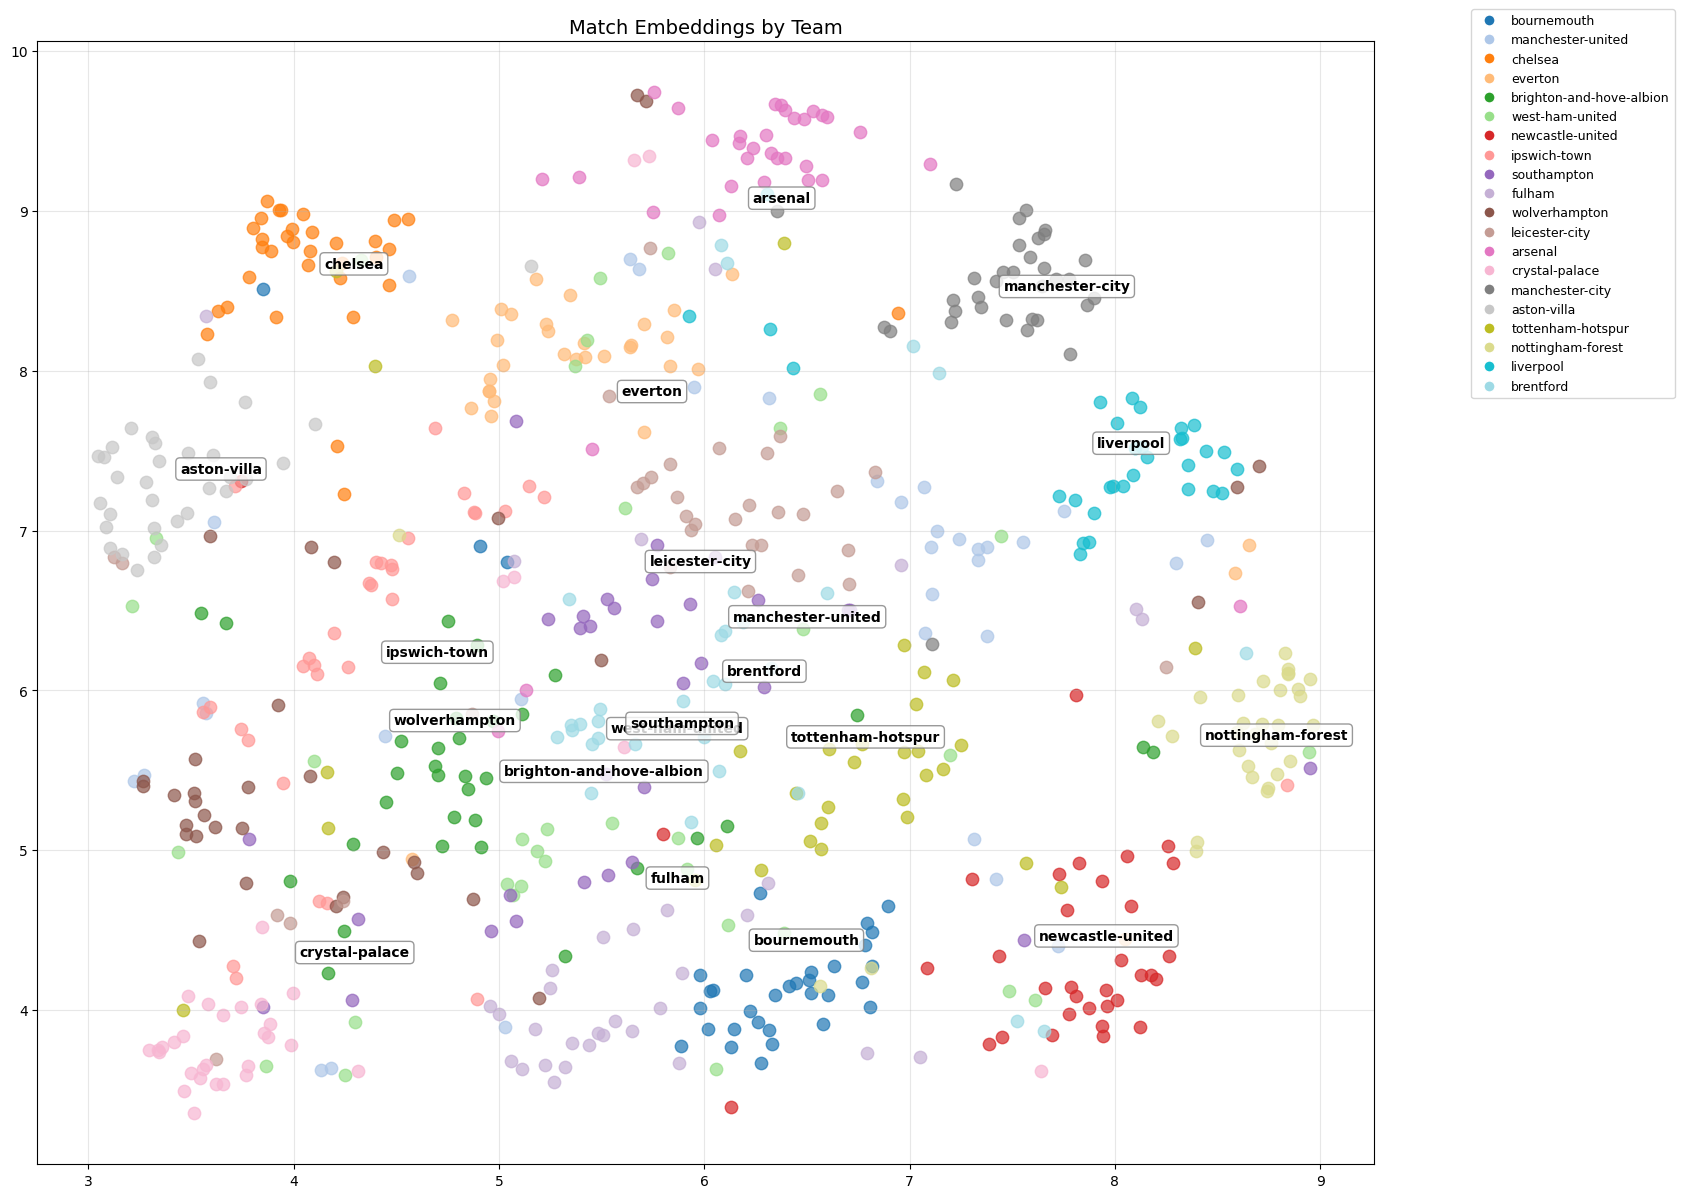

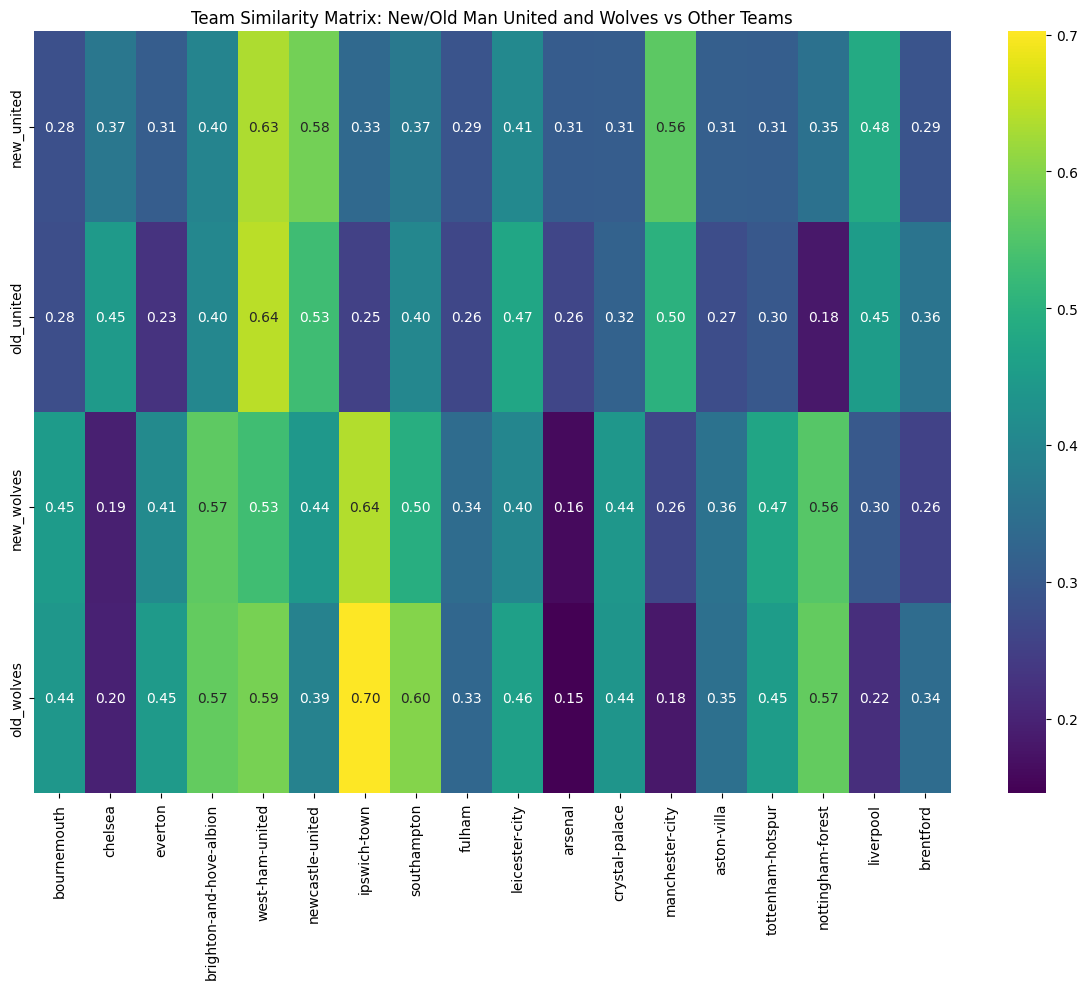

team: bournemouth, std: 1.381402210827678

team: manchester-united, std: 1.4133032158408751

team: chelsea, std: 1.4556595468143332

team: everton, std: 1.4453485582849117

team: brighton-and-hove-albion, std: 1.3810880607909288

team: west-ham-united, std: 1.359133692094814

team: newcastle-united, std: 1.4251056912316198

team: ipswich-town, std: 1.4231026111141878

team: southampton, std: 1.3440876439878926

team: fulham, std: 1.3915566888781186

team: wolverhampton, std: 1.3248043719714144

team: leicester-city, std: 1.402333374428476

team: arsenal, std: 1.49812478556587

team: crystal-palace, std: 1.4007856733655368

team: manchester-city, std: 1.4981921239065832

team: aston-villa, std: 1.475530342080465

team: tottenham-hotspur, std: 1.4587313478867558

team: nottingham-forest, std: 1.4271395295430345

team: liverpool, std: 1.483851371216594

team: brentford, std: 1.4137110307698142



/Users/fred/Documents/GitHub/embeddings/football-embeddings/venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/fred/Documents/GitHub/embeddings/football-embeddings/venv/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


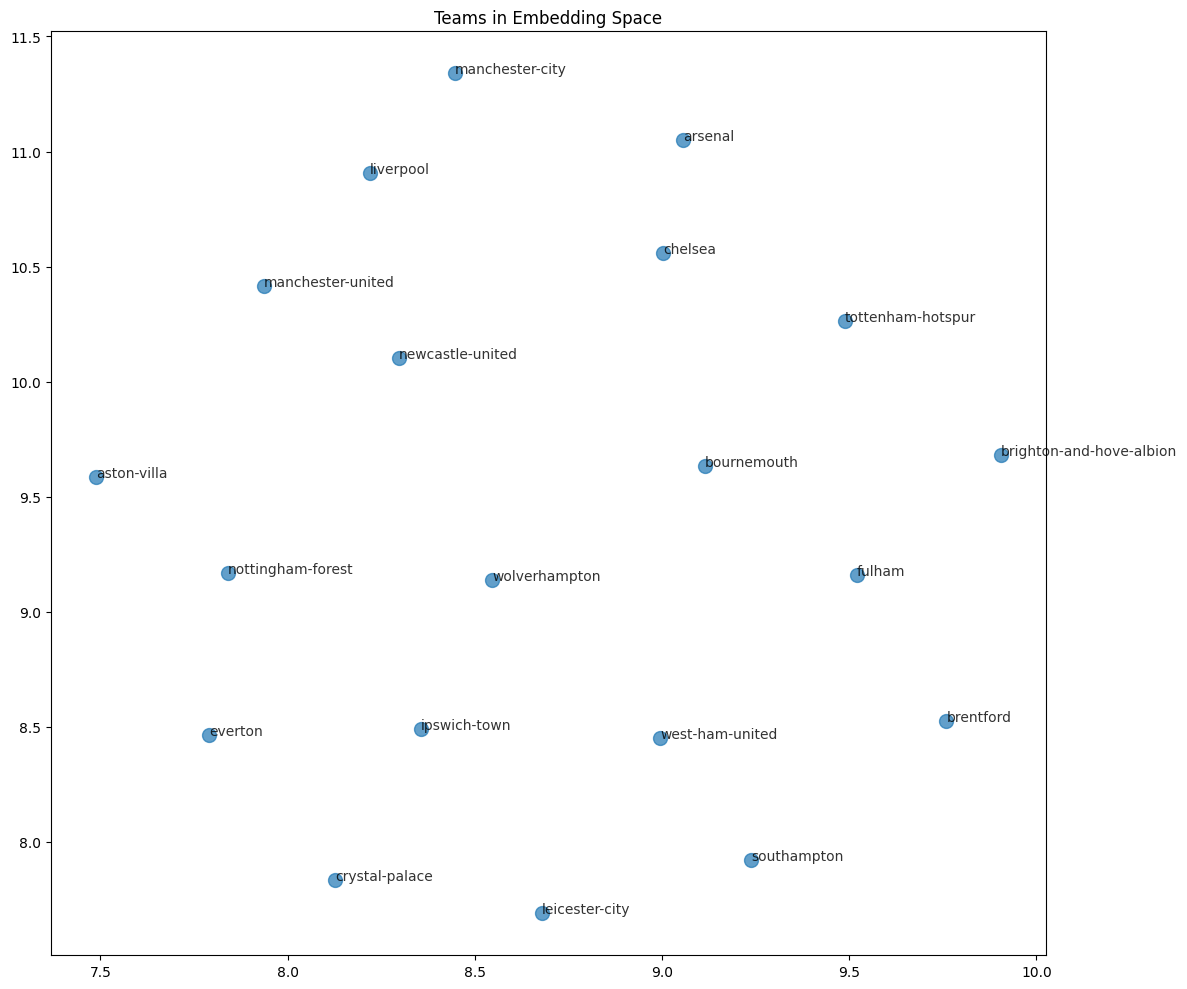

In [109]:
if __name__ == "__main__":
    # Load dataset
    df = pd.read_csv('match_r_s.csv')
    
    # Convert numerical columns to appropriate types
    numerical_cols = [col for col in df.columns if col not in ['id', 'thisTeamName', 'date', 'report', 
                                                             'doc_id', 'oppTeamName', 'thisManagerName', 
                                                             'oppManagerName', 'roundInfo']]
    df[numerical_cols] = df[numerical_cols].apply(pd.to_numeric, errors='coerce')
    df[numerical_cols] = df[numerical_cols].fillna(0)
    
    # Run the complete analysis
    results = build_hybrid_embedding_model(df)
    
    # Visualise
    team_embeddings, embeddings_2d, team_names = visualise_team_embeddings(df, results['hybrid_vectors'])
    team_comparison_matrix(df,results['hybrid_vectors'])
    embeddings_2d, team_match_indices, team_colors = visualise_team_average_embeddings(df, results['hybrid_vectors'])
    